# Experiment Overview: Free Trial Screener
In the experiment, Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead. This screenshot shows what the experiment looks like.

**The hypothesis** was that this might set clearer expectations for students upfront **thus reducing the number of frustrated students** who left the free trial because they didn't have enough time—**without significantly reducing the number of students to continue past the free trial and eventually complete the course**.




### Evaluation Metrics

**Enrollment Rate:** number of users complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. (dmin= 0.01)

**Retention:** number of users to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of users to complete checkout. (dmin=0.01)

**Conversion Rate:** number of users to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. (dmin= 0.0075)

## The goals of the experiment in the practical meaning:
 
- Reduce number of enrollments that eventually fall out after 2 weeks of free trial 

- Retain or imcrease the number of payments

## The goals of the experiment in terms of our metrics:

- the enrollment rate should decrease

- the net conversion should not decrease

In [1]:
reset -sf

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import beta
import seaborn as sns
%pylab inline

In [3]:
control = pd.read_excel(open('data/data.xlsx','rb'), sheet_name='Control')
control = control.fillna(0)
experiment = pd.read_excel(open('data/data.xlsx','rb'), sheet_name='Experiment')
experiment = experiment.fillna(0)

In [4]:
def p_is_passed(is_passed, metric="metric"):
    if is_passed:
        print(f"{metric} passed ✅")
    else:
        print(f"{metric} failed")
    return is_passed

# Frequentist - A/B Testing

## 1. Sample Size

 <img src="image/samplesize0.png">


 <img src="image/size.png">


The retention rate takes too long to test, hence will be eliminated from evaluation metrics. The remaining metrics are the gross conversion rate and the net conversion rate.

- gross conversion rate:  enroll/click
- net conversion rate: payment/click


## 2. Sanity Checks

<img src="image/sanitycheck.png">


In [5]:
def sanity_check(c, e, metric="metric"):
    #c : control value 
    #e: experiment value
    marginal_er = 1.96 * np.sqrt(0.5*0.5/(c+e)) 
    c_lci = 0.5 - marginal_er
    c_uci = 0.5 + marginal_er
    obs_value = c/(c+e)
    p_is_passed(c_lci < obs_value < c_uci, metric)

In [6]:
sanity_check(control.Pageviews.sum(), experiment.Pageviews.sum(), "Number of cookies")
sanity_check(control.Clicks.sum(), experiment.Clicks.sum(), "Number of clicks")

Number of cookies passed ✅
Number of clicks passed ✅


## 3. Check for Practical and Statistical Significance

<img src="image/practicalsignificance.png">


In [7]:
def pratical_significance(c_x, c_n, e_x, e_n, dmin, metric="metric"):
    c_p, e_p = c_x/c_n, e_x/e_n
    pooled_prob = (c_x+e_x)/(c_n+e_n)
    margin_error = 1.96*(np.sqrt(((c_p*(1-c_p))/c_n)+((e_p*(1-e_p))/e_n)))
    lci = (c_p-e_p) - margin_error
    uci = (c_p-e_p) + margin_error
    is_passed = p_is_passed(lci<dmin<uci, metric)
    if is_passed: print("statistically significant")
    else: print("not statistically significant")
    print(f'LCI: {(lci):.2} - UCI: {uci:.2} Dmin: {dmin}')


#### Gross conversion

statistically significant 

In [8]:
pratical_significance(control.Enrollments.sum(), control.Clicks.sum(),
                        experiment.Enrollments.sum(), experiment.Clicks.sum(),
                        0.01, "gross conversion")

gross conversion passed ✅
statistically significant
LCI: 0.007 - UCI: 0.018 Dmin: 0.01


#### Net Conversion

not statistically significant


In [9]:
pratical_significance(control.Payments.sum(), control.Clicks.sum(), 
                        experiment.Payments.sum(), experiment.Clicks.sum(), 
                        0.0075, "net conversion")


net conversion failed
not statistically significant
LCI: -0.0012 - UCI: 0.0072 Dmin: 0.0075


## 4. Conclusion



I recommend not to launch this experiment.

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time — without significantly reducing the number of students to continue past the free trial and eventually complete the course.

- First, based on effect size test and sign test, the enrollment rate in experiment group is significantly and practically lower than control group. In other words, the number of students who choose to enroll in free trial indeed decreases due to the warning, which aligns with what null hypothesis expects to happen.

- Then, since net conversion rate is not statistically significant, the number of students who eventually pass the free trial and make a payment is not different among experiment and control group. At this point, we can conclude that the hypothesis is correct. However, the lower bound of confidence interval is actually lower than lower bound of practical significance level, indicating this change might bring negative impact and we should be cautious about this result. I highly suggest that we need more investigation to this before launching this change. With the data that we have, it's better to not launch this change.



# Bayesian A/B Testing

In [10]:
def posterior_distribution(control_alpha, control_beta, experiment_alpha, experiment_beta):
    #x: probability/rate
    #y: probability density function

    #updating posterior distribution
    i = 0
    if i != len(control):
        c_pos_alpha, c_posterior_beta = control_alpha[i] + control_alpha[i+1], control_beta[i] + control_beta[i+1]
        e_pos_alpha, e_posterior_beta = experiment_alpha[i] + experiment_alpha[i+1], experiment_beta[i] + experiment_beta[i+1]
        i+=1
    return c_pos_alpha, c_posterior_beta, e_pos_alpha, e_posterior_beta

In [11]:
def plot_with_fill(x, y, label):
    #x: probability/rate
    #y: probability density function
    lines = plt.plot(x, y, label=label, lw=2)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_c())

# Gross Conversion

>gross conversion = enroll/click

In [12]:
control_enrollment = control.Enrollments
control_noenrollment = control.Clicks - control.Enrollments
control_click = control.Clicks

experiment_enrollment = experiment.Enrollments
experiment_noenrollment = experiment.Clicks - experiment.Enrollments
experiment_click = experiment.Clicks

x = np.linspace(0., 1, 1000) #random probability


## Prior Distribution

In [13]:
print(f'Prior Control Gross Conversion Rate: {(control_enrollment[0]/control_click[0]):.3}')
print(f'Prior Experiment Gross Conversion Rate: {(experiment_enrollment[0]/experiment_click[0]):.3}')

Prior Control Gross Conversion Rate: 0.195
Prior Experiment Gross Conversion Rate: 0.153


In [14]:
## Get prior distribution
c_distribution_gc_prior = stats.beta.pdf(x, control_enrollment[0], control_noenrollment[0])
e_distribution_gc_prior  = stats.beta.pdf(x, experiment_enrollment[0], experiment_noenrollment[0])

<Figure size 432x288 with 0 Axes>

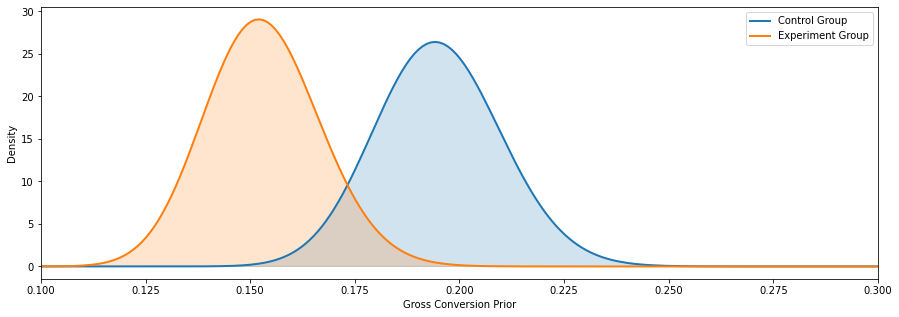

In [15]:
plt.figure(2)
plt.figure(figsize=(15,5))
plot_with_fill(x, c_distribution_gc_prior , 'Control Group')
plot_with_fill(x, e_distribution_gc_prior , 'Experiment Group')
plt.xlim(xmax=0.3)
plt.xlim(xmin = 0.1)
plt.xlabel('Gross Conversion Prior')
plt.ylabel('Density')
plt.legend()
plt.show()

## Posterior Distribution

In [16]:
c_pos_alpha_gc, c_posterior_beta_gc, e_pos_alpha_gc, e_posterior_beta_gc = posterior_distribution(control_enrollment,control_noenrollment,experiment_enrollment,experiment_noenrollment)
c_distribution_gc_posterior = stats.beta.pdf(x, c_pos_alpha_gc, c_posterior_beta_gc)
e_distribution_gc_posterior  = stats.beta.pdf(x, e_pos_alpha_gc, e_posterior_beta_gc)

<Figure size 432x288 with 0 Axes>

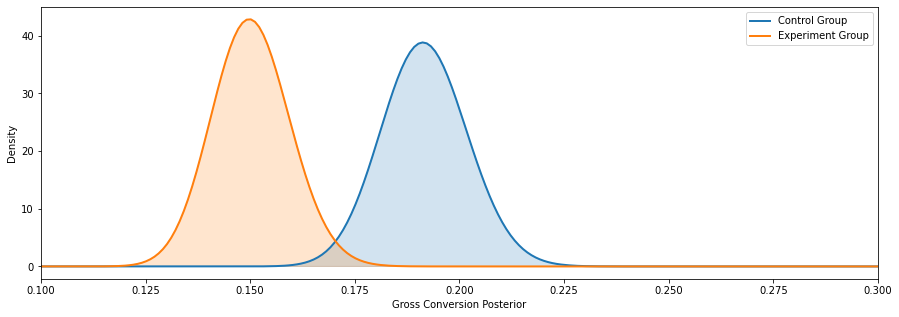

In [17]:
plt.figure(2)
plt.figure(figsize=(15,5))
plot_with_fill(x, c_distribution_gc_posterior , 'Control Group')
plot_with_fill(x, e_distribution_gc_posterior , 'Experiment Group')
plt.xlim(xmax=0.3)
plt.xlim(xmin = 0.1)
plt.xlabel('Gross Conversion Posterior')
plt.ylabel('Density')
plt.legend()
plt.show()

## Simulations


In [18]:
# generate random samples from each distribution
sim_size = 10000
c_rand_gc = np.random.beta(c_pos_alpha_gc, c_posterior_beta_gc, sim_size)
e_rand_gc = np.random.beta(e_pos_alpha_gc, e_posterior_beta_gc, sim_size)

### Experiment > Control

In [19]:
## Experiment > control
c_gcr_small_gc = 0
e_grc_small_gc = 0

for i in range(sim_size):
    if e_rand_gc[i] >= c_rand_gc[i]:
        e_grc_small_gc += 1
    else:      
        c_gcr_small_gc += 1
likelihood = e_grc_small_gc*100 / sim_size

print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group outperforms the Control group in GCR is {likelihood:.3}%")


Base on a simulation of 10000 samples,
the likelihood that the Experiment group outperforms the Control group in GCR is 0.16%


In [20]:
# Experiment > Control by k percentage
c_gcr_small_gc = 0
e_grc_small_gc = 0
diffs_gc = np.zeros(sim_size)
percentage = 0.01

for i in range(sim_size):
    diffs_gc[i] = c_rand_gc[i] - e_rand_gc[i]
    if  e_rand_gc[i] - percentage <= c_rand_gc[i]:
        e_grc_small_gc += 1
    else:      
        c_gcr_small_gc += 1
likelihood = e_grc_small_gc*100 / sim_size

print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group outperforms the Control group in GCR by at least {int(percentage*100)}% is {likelihood:.3}%")



Base on a simulation of 10000 samples,
the likelihood that the Experiment group outperforms the Control group in GCR by at least 1% is 1e+02%


### Experiment < Control

In [21]:
# Experiment < Control

# Gross Conversion Rate
c_gcr_small_gc = 0
e_grc_small_gc = 0
for i in range(sim_size):
    if e_rand_gc[i] <= c_rand_gc[i]:
        e_grc_small_gc += 1
    else:      
        c_gcr_small_gc += 1
likelihood = e_grc_small_gc*100 / sim_size


print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group underperforms the Control group in GCR is {likelihood:.3}%")


Base on a simulation of 10000 samples,
the likelihood that the Experiment group underperforms the Control group in GCR is 99.8%


In [22]:
# Experiment < Control by k percentage
c_gcr_small_gc = 0
e_grc_small_gc = 0
diffs_gc = np.zeros(sim_size)
percentage = 0.03

for i in range(sim_size):
    diffs_gc[i] = c_rand_gc[i] - e_rand_gc[i]
    if  e_rand_gc[i] + percentage <= c_rand_gc[i]:
        e_grc_small_gc += 1
    else:      
        c_gcr_small_gc += 1
likelihood = e_grc_small_gc*100 / sim_size
        
print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group underperforms the Control group in GCR by at least {int(percentage*100)}% is {likelihood:.3}%")


Base on a simulation of 10000 samples,
the likelihood that the Experiment group underperforms the Control group in GCR by at least 3% is 79.7%


<img src="image/enrollmenttable.png">


# Net Coversion

net conversion = payment/click

In [23]:
control_payment = control.Payments
control_nopayment = control.Clicks - control.Payments
experiment_payment = experiment.Payments
experiment_nopayment = experiment.Clicks - experiment.Payments

## Prior Distribution

In [24]:
print(f'Prior Control Net Conversion Rate: {(control_payment[0]/control_click[0]):.3}')
print(f'Prior Experiment Net Conversion Rate: {(experiment_payment[0]/experiment_click[0]):.3}')

Prior Control Net Conversion Rate: 0.102
Prior Experiment Net Conversion Rate: 0.0496


In [25]:
## Get prior distribution
c_distribution_nc_prior = stats.beta.pdf(x, control_payment[0], control_nopayment[0])
e_distribution_nc_prior  = stats.beta.pdf(x, experiment_payment[0], experiment_nopayment[0])

<Figure size 432x288 with 0 Axes>

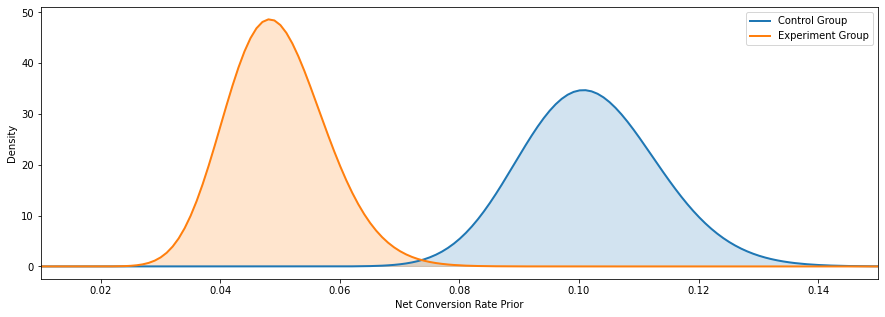

In [26]:
plt.figure(2)
plt.figure(figsize=(15,5))
plot_with_fill(x, c_distribution_nc_prior, 'Control Group')
plot_with_fill(x, e_distribution_nc_prior, 'Experiment Group')
plt.xlim(xmax=0.15)
plt.xlim(xmin=0.01)
plt.xlabel('Net Conversion Rate Prior')
plt.ylabel('Density')
plt.legend()
plt.show()

## Posterior Distribution

In [27]:
c_pos_alpha_nc, c_posterior_beta_nc, e_pos_alpha_nc, e_posterior_beta_nc = posterior_distribution(control_payment,control_nopayment,experiment_payment,experiment_nopayment)
c_distribution_nc_posterior = stats.beta.pdf(x, c_pos_alpha_nc, c_posterior_beta_nc)
e_distribution_nc_posterior  = stats.beta.pdf(x, e_pos_alpha_nc, e_posterior_beta_nc)

<Figure size 432x288 with 0 Axes>

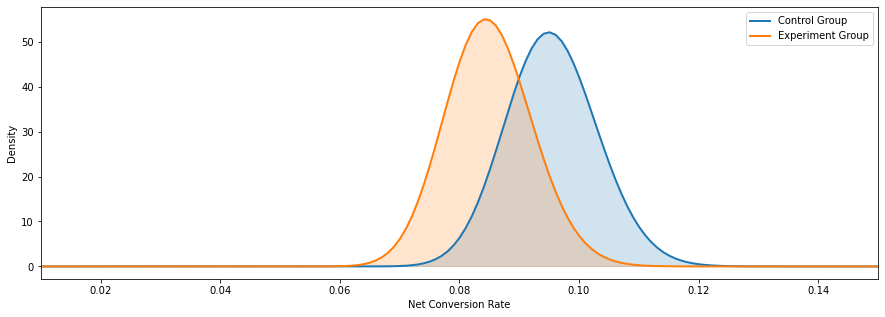

In [28]:
plt.figure(2)
plt.figure(figsize=(15,5))
plot_with_fill(x, c_distribution_nc_posterior, 'Control Group')
plot_with_fill(x, e_distribution_nc_posterior, 'Experiment Group')
plt.xlim(xmax=0.15)
plt.xlim(xmin = 0.01)
plt.xlabel('Net Conversion Rate')
plt.ylabel('Density')
plt.legend()
plt.show()

## Simulations

In [29]:
# generate random samples from each distribution
sim_size = 10000
c_rand_ncr = np.random.beta(c_pos_alpha_nc, c_posterior_beta_nc, sim_size)
e_rand_ncr = np.random.beta(e_pos_alpha_nc, e_posterior_beta_nc, sim_size)

### Experiment > Control

In [30]:
# Experiment > Control 

# Net Conversion Rate
c_ncr_large = 0
e_ncr_large = 0
for i in range(sim_size):
    if e_rand_ncr[i] >= c_rand_ncr[i]:
        e_ncr_large += 1
    else:      
        c_ncr_large += 1
likelihood = e_ncr_large*100 / sim_size

print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group outperforms the Control group in NCR is {likelihood:.3}%")


Base on a simulation of 10000 samples,
the likelihood that the Experiment group outperforms the Control group in NCR is 15.7%


In [31]:
# Experiment > Control by k percentage

# Net Conversion Rate
c_ncr_large = 0
e_ncr_large = 0
percentage = 0.01

for i in range(sim_size):
    if e_rand_ncr[i] - percentage >= c_rand_ncr[i]:
        e_ncr_large += 1
    else:      
        c_ncr_large += 1
likelihood = e_ncr_large*100 / sim_size

print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group outperforms the Control group in NCR by at least {int(percentage*100)}% is {likelihood:.3}%")


Base on a simulation of 10000 samples,
the likelihood that the Experiment group outperforms the Control group in NCR by at least 1% is 2.52%


### Experiment < Control

In [32]:
# Experiment < Control 

# Net Conversion Rate
c_ncr_large = 0
e_ncr_large = 0
for i in range(sim_size):
    if e_rand_ncr[i] <= c_rand_ncr[i]:
        e_ncr_large += 1
    else:      
        c_ncr_large += 1

likelihood = e_ncr_large*100 / sim_size

print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group outperforms the Control group in NCR is {likelihood:.3}%")


Base on a simulation of 10000 samples,
the likelihood that the Experiment group outperforms the Control group in NCR is 84.3%


In [33]:
# Experiment < Control by k percentage

# Net Conversion Rate
c_ncr_large = 0
e_ncr_large = 0
percentage = 0.03

for i in range(sim_size):
    if e_rand_ncr[i] + percentage >= c_rand_ncr[i]:
        e_ncr_large += 1
    else:      
        c_ncr_large += 1
likelihood = e_ncr_large*100 / sim_size

print(f"Base on a simulation of {sim_size} samples,")
print(f"the likelihood that the Experiment group outperforms the Control group in NCR by at least {int(percentage*100)}% is {likelihood:.3}%")



Base on a simulation of 10000 samples,
the likelihood that the Experiment group outperforms the Control group in NCR by at least 3% is 96.8%


<img src="image/conversionratetable.png">


## Conclusion

Udacity has 99% & 84% chance respectively to the gross conversion rate and the net conversion rate that the expriment group performs worse than the control group. It's best to not launch the experiment. 

Bayesian A/B Testing allows Udacity to know the confidence of the result as well as the cost/benefits associated with each option. 